In [1]:
import torch         # Base PyTorch library for tensor operations.
import torch.nn as nn
import torch.nn.functional as F       # Contains activation functions (e.g., `elu`, `log_softmax`) and loss functions (e.g., `nll_loss`).
from torch_geometric.datasets import Planetoid           # Downloads standard citation network datasets (Cora, Citeseer, Pubmed)
from torch_geometric.transforms import NormalizeFeatures # Normalizes node features to sum to 1 (helps training)
from torch_geometric.nn import SAGEConv                  # Pre-built graphSAGE layer from PyTorch Geometric.
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# 1. Download and preprocess data

# Device Configuration - Purpose: Use GPU if available for faster training.
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Load Cora dataset with normalized features
dataset = Planetoid(root='C:/Users/Majid/Downloads/CNN', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)  # Move graph data to GPU/CPU

# Print dataset info
print(f"Dataset: {dataset}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: Cora()
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


In [3]:
# =============================================
# 2. Define GraphSAGE Model
# =============================================

class GraphSAGE(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_features, hidden_features)
        self.conv2 = SAGEConv(hidden_features, out_features)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
model = GraphSAGE(
    in_features=dataset.num_features,
    hidden_features=128,
    out_features=dataset.num_classes
)

In [4]:
# =============================================
# 3. Training Setup
# =============================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()

In [5]:
# =============================================
# 4. Training Loop
# =============================================

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [6]:
# =============================================
# 5. Evaluation
# =============================================
def test():
    model.eval()
    out = model(data.x, data.edge_index)

    pred = out.argmax(dim=1)
        
    # Calculate accuracy for each split
    train_acc = accuracy_score(
        data.y[data.train_mask].cpu(),
        pred[data.train_mask].cpu()
    )
    val_acc = accuracy_score(
        data.y[data.val_mask].cpu(),
        pred[data.val_mask].cpu()
    )
    test_acc = accuracy_score(
        data.y[data.test_mask].cpu(),
        pred[data.test_mask].cpu()
    )
    
    return train_acc, val_acc, test_acc


In [7]:
# Training loop
# Runs for 100 complete passes through the dataset
losses = []
for epoch in range(51):
    
    loss = train()
    losses.append(loss)

    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 000, Loss: 1.9470, Train: 0.2214, Val: 0.0720, Test: 0.0920
Epoch: 010, Loss: 1.2699, Train: 1.0000, Val: 0.7380, Test: 0.7460
Epoch: 020, Loss: 0.3098, Train: 1.0000, Val: 0.7780, Test: 0.7970
Epoch: 030, Loss: 0.1079, Train: 1.0000, Val: 0.7800, Test: 0.7960
Epoch: 040, Loss: 0.1013, Train: 1.0000, Val: 0.7640, Test: 0.7860
Epoch: 050, Loss: 0.1010, Train: 1.0000, Val: 0.7680, Test: 0.7930


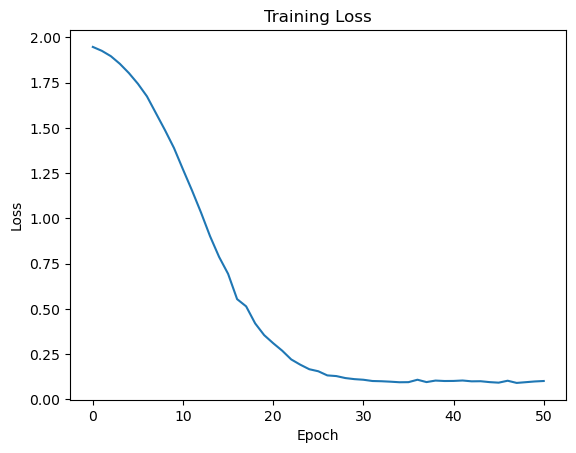

In [8]:
# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [9]:
# Final evaluation
train_acc, val_acc, test_acc = test()
print(f'Final results: Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Final results: Train: 1.0000, Val: 0.7680, Test: 0.7930
